**Indexes for Image Classes:**
0. Black-grass
1. Charlock
2. Cleavers
3. Common Chickweed
4. Common Wheat
5. Fat Hen
6. Loose Silky-bent
7. Maize
8. Scentless Mayweed
9. Shepherd's Purse
10. Small-flowered Cranesbill
11. Sugar Beet

In [1]:
# Mount google drive to notebook.
from google.colab import drive
drive.mount('/content/drive/')

# To force remounting google drive to notebook.
#drive.mount('/content/drive', force_remount = True)

# Dismount google drive from notebook.
#drive.flush_and_unmount()

# Ensure we are in the correct working directory.
%cd /content/drive/MyDrive/CX4041-Group-Project/
%ls\

Mounted at /content/drive/
/content/drive/MyDrive/CX4041-Group-Project
 Augmented_Test_Images/
 Augmented_Train_Images/
 Checkpoint/
 CSV/
'CX4041 Group Project Report.docx'
 Model-Figures/
 Notebooks/
 Preprocessed_Test_Images/
 Preprocessed_Train_Images/
'[Video Presentation] StoryBoard & Script.gdoc'


In [2]:
# Import the required libraries.
import os
import numpy as Numpy
import pandas as Pandas
import tensorflow as TensorFlow
import matplotlib.pyplot as Pyplot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import load_model
from keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image
from natsort import natsorted

# Enable type promotion in TensorFlow and change type inference when converting literals to tensors to strictly follow the NumPy standard.
np_config.enable_numpy_behavior()

# Check TensorFlow version and ensure that the GPU is being used.
print('Tensorflow version: ', TensorFlow.__version__)

Tensorflow version:  2.8.0


In [3]:
# Define the width and height of the input images.
width = 299
height = 299
batch_size = 16

# Define an instance of the Xception model that we are going to adapt.
# Original weights will be downloaded on the first run and stored locally.
partial_model = Xception(
    
    # Whether to include the last 3 fully connected (dense) layers of the Xception network.
    # Set to false here because we are using a larger image size than ImageNet.
    include_top = False,

    # Reuse the weights from the pretraining of the 'imagenet' model.
    weights = 'imagenet',

    # Keras tensor to use as an input image to the model.
    input_tensor = None,

    # Shape tuple set to the dimensions of the input images.
    input_shape = (width, height, 3),

    # Pooling mode for feature extraction.
    pooling = 'avg'
)

# View a summary of the cropped Xception model.
print(type(partial_model), '\n')
print(partial_model.summary())

# Note: The convolutional layers act as feature extractors while the fully connected (dense/top) layers
# serve to interpret the extracted features from the images to classify them.

83697664/83683744 [==============================] - 1s 0us/step
<class 'keras.engine.functional.Functional'> 

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv

In [4]:
# Freeze the weights for the Xception model during training if necessary.
# partial_model.trainable = False;

# Add new fully connected (dense) layers that will serve as the classifier.
# Two fully connected layers are sufficient for most convolutional networks.
# Add layers using keras Functional application programming interface.
flattened = Flatten()(partial_model.layers[-1].output)
dense = Dense(1024, activation = 'relu', activity_regularizer = regularizers.l2(1e-5))(flattened)

# Dropouts disable a specified percentage of neurons during the backpropagation update
# process so that the other neurons can be sufficiently updated and all the neurons train
# to a relatively equal degree, preventing underfitting or overfitting of specific neurons.
dropout = Dropout(0.5)(dense)

# Number of nodes in the last layer must match the number of classification categories.
# Softmax activation function outputs a vector of probability values that sum to 1.0 and
# can be interpreted as the probability that an input belongs to a specific class.
prediction = Dense(12, activation = 'softmax', activity_regularizer = regularizers.l2(1e-5))(dropout)

# Define the modified Xception model with our own fully connected layers.
xception_model = Model(inputs = partial_model.inputs, outputs = prediction)

# View a summary of our modified Xception model.
print(type(xception_model), '\n')
print(xception_model.summary())

<class 'keras.engine.functional.Functional'> 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )              

In [5]:
# Define the optimizer. Use a small learning rate so as to not change the imagenet weights too much.
xception_optimizer = Adam(learning_rate = 0.0001)

# Define the loss function.
xception_loss = SparseCategoricalCrossentropy()

# Compile the model.
xception_model.compile(
    optimizer = xception_optimizer,
    loss = xception_loss,
    metrics = ['accuracy']
)

In [6]:
# Prepare the training and test plant images datasets.
plant_training_dataset = image_dataset_from_directory(
    # Directory path for all the images.
    '/content/drive/MyDrive/CX4041-Group-Project/Preprocessed_Train_Images/',
    
    # Generate labels automatically based on the directory structure, one class per folder of plant type.
    labels = 'inferred',

    # Set to type 'int' as we are using sparse categorical crossentropy loss, where each sample belongs to exactly one class.
    label_mode = 'int',

    # If class names must be explictly stated.
    class_names = None,

    # Colour format to read in the images.
    color_mode = 'rgb',

    # Dimensions of the input images.
    image_size = (width, height),

    # Batch size.
    batch_size = batch_size,

    # Randomly shuffle the data.
    shuffle = True,

    # Set the random seed to the same fixed value for both to ensure mutual exclusion of samples for training and validation.
    seed = 0,

    # Fraction of data in the original dataset to put aside for validation.
    validation_split = 0.1,

    # Determines which portion of the dataset is returned, which in this case is the remaining 70% not used for validation.
    subset = 'training'
)
print(type(plant_training_dataset), '\n')

plant_validation_dataset = TensorFlow.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/CX4041-Group-Project/Preprocessed_Train_Images/',
    labels = 'inferred',
    label_mode = 'int',
    class_names = None,
    color_mode = 'rgb',
    image_size = (width, height),
    batch_size = batch_size,
    shuffle = True,
    seed = 0,
    validation_split = 0.1,
    subset = 'validation'
)
print(type(plant_validation_dataset))

Found 12000 files belonging to 12 classes.
Using 10800 files for training.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> 

Found 12000 files belonging to 12 classes.
Using 1200 files for validation.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [7]:
# View the class names.
print('Identified class names:', plant_training_dataset.class_names, '\n')

# Total number of batches is the celing of (training size / batch size).
for image_batch, label_batch in plant_training_dataset:

  # All batches in training and validation datasets have the same shape for image and labels.
  print('Training dataset - Image batch shape:', image_batch.shape, ', Label batch shape:', label_batch.shape)
  break

# Total number of batches is the celing of (validation size / batch size).
for image_batch, label_batch in plant_validation_dataset:
  print('Validation dataset - Image batch shape:', image_batch.shape, ', Label batch shape:', label_batch.shape)
  break

Identified class names: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet'] 

Training dataset - Image batch shape: (16, 299, 299, 3) , Label batch shape: (16,)
Validation dataset - Image batch shape: (16, 299, 299, 3) , Label batch shape: (16,)


In [8]:
# Create the output directory for the model checkpoint if it does not exist.
if not os.path.isdir('/content/drive/MyDrive/CX4041-Group-Project/Checkpoint/Xception-Checkpoint/'):
    os.mkdir('/content/drive/MyDrive/CX4041-Group-Project/Checkpoint/Xception-Checkpoint/')

# callback for early stoppping with patience of 5 epochs based on val_loss
early_stopping = EarlyStopping(
    monitor = 'val_loss', 
    patience = 5
    )

# callback for model checkpoint to save the model with the best performance
model_checkpoint = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/CX4041-Group-Project/Checkpoint/Xception-Checkpoint/',
    save_best_only = True,
    monitor = 'val_loss',
    mode = 'min'
    )

# Define the function that will gradually reduce the learning rate.
def learning_rate_decay_scheduler(epochs, current_learning_rate):
  
  # Specify after how many epochs should the learning rate start to reduce.
  if epochs < 5:
    return current_learning_rate
  else:
    new_learning_rate = current_learning_rate * 0.95
    return new_learning_rate

# Callback for decaying the learning rate exponentially.
learning_rate_decay = LearningRateScheduler(learning_rate_decay_scheduler)

In [9]:
# Train the modified Xception model.
xception_history = xception_model.fit(
    plant_training_dataset,
    batch_size = batch_size,
    epochs = 100,
    verbose = 2,
    shuffle = True,
    validation_data = plant_validation_dataset,
    callbacks = [early_stopping, model_checkpoint, learning_rate_decay]
    #use_multiprocessing = True
)

Epoch 1/100
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CX4041-Group-Project/Checkpoint/Xception-Checkpoint/assets
675/675 - 2084s - loss: 0.3601 - accuracy: 0.8830 - val_loss: 0.1221 - val_accuracy: 0.9567 - lr: 1.0000e-04 - 2084s/epoch - 3s/step
Epoch 2/100
675/675 - 172s - loss: 0.1067 - accuracy: 0.9640 - val_loss: 0.1534 - val_accuracy: 0.9500 - lr: 1.0000e-04 - 172s/epoch - 255ms/step
Epoch 3/100
675/675 - 172s - loss: 0.0760 - accuracy: 0.9749 - val_loss: 0.1252 - val_accuracy: 0.9633 - lr: 1.0000e-04 - 172s/epoch - 254ms/step
Epoch 4/100
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CX4041-Group-Project/Checkpoint/Xception-Checkpoint/assets
675/675 - 187s - loss: 0.0553 - accuracy: 0.9834 - val_loss: 0.0945 - val_accuracy: 0.9717 - lr: 1.0000e-04 - 187s/epoch - 277ms/step
Epoch 5/100
675/675 - 172s - loss: 0.0322 - accuracy: 0.9912 - val_loss: 0.1219 - val_accuracy: 0.9675 - lr: 1.0000e-04 - 172s/epoch - 254ms/step
Epoch 6/100
INFO:tensorflow:Assets wr

In [10]:
# View model accuracies and losses.
print('Training dataset accuracy = %3.3f'%(xception_history.history['accuracy'][-1]))
print('Test dataset accuracy = %3.3f'%(xception_history.history['val_accuracy'][-1]))
print('Training datset loss = %3.3f'%(xception_history.history['loss'][-1]))
print('Test dataset loss = %3.3f'%(xception_history.history['val_loss'][-1]))

Training dataset accuracy = 0.999
Test dataset accuracy = 0.989
Training datset loss = 0.007
Test dataset loss = 0.048


In [11]:
# Create a directory for the model figures if it does not exist.
if not os.path.isdir('/content/drive/MyDrive/CX4041-Group-Project/Model-Figures/'):
    os.makedirs('/content/drive/MyDrive/CX4041-Group-Project/Model-Figures/')

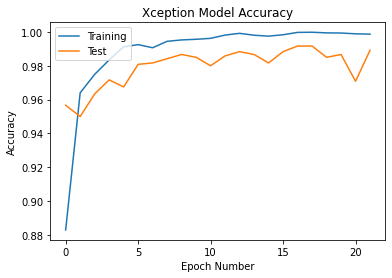

In [12]:
# Plot model accuracies.
Pyplot.plot(xception_history.history['accuracy'])
Pyplot.plot(xception_history.history['val_accuracy'])
Pyplot.title('Xception Model Accuracy')
Pyplot.ylabel('Accuracy')
Pyplot.xlabel('Epoch Number')
Pyplot.legend(['Training', 'Test'], loc = 'upper left')
Pyplot.savefig('/content/drive/MyDrive/CX4041-Group-Project/Model-Figures/Xception Model Accuracies.png')

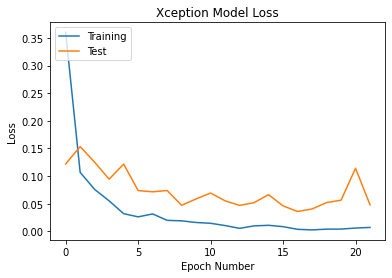

In [13]:
# Plot model losses.
Pyplot.plot(xception_history.history['loss'])
Pyplot.plot(xception_history.history['val_loss'])
Pyplot.title('Xception Model Loss')
Pyplot.ylabel('Loss')
Pyplot.xlabel('Epoch Number')
Pyplot.legend(['Training', 'Test'], loc = 'upper left')
Pyplot.savefig('/content/drive/MyDrive/CX4041-Group-Project/Model-Figures/Xception Model Losses.png')

In [14]:
# ALTERNATIVE: Load a previously saved checkpoint if desired. Load in the pretrained model checkpoint optimal weights and bias.
checkpoint_path = '/content/drive/MyDrive/CX4041-Group-Project/Checkpoint/Xception-Checkpoint/'

# Check that the checkpoint directory exists.
if os.path.isdir(checkpoint_path):

  # Check that the checkpoint directory is not empty.
  if len(os.listdir(checkpoint_path)) > 0:

    # Load the perviously saved best model checkpoint weights and biases.
    xception_model = load_model(checkpoint_path)
    print('Model checkpoint successfully loaded.')
    print(type(xception_model))
  else:
    print('Checkpoint directory is empty and contains no checkpoint to load.')
else:
  print('Checkpoint directory has not been created and no checkpoint exists.')

Model checkpoint successfully loaded.
<class 'keras.engine.functional.Functional'>


**Prediction of plant class performed below.**

In [15]:
# Create a dictionary matching prediction index to their classes.
species_dictionary = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
}

In [16]:
# Directory where the test images are stored.
test_images_path = '/content/drive/MyDrive/CX4041-Group-Project/Preprocessed_Test_Images/test/'
test_images_list = []
count = 0

# For each item in the directory of test images.
for test_image_name in os.listdir(test_images_path):

  # Check if the item is a file.
  if os.path.isfile(test_images_path + test_image_name):

    # Add the test image name to a list.
    test_images_list.append(test_image_name)
    count += 1

print('Number of test images detected:', count, '\n')

# Sort the images in the list by name. Use the 'natsorted' package to ensure the filenames are sorted properly by number.
test_images_list = natsorted(test_images_list)

Number of test images detected: 794 



In [17]:
# Perform resizing of the test images before feeding into the neural network.
for image_index in range(len(test_images_list)):

  # Retrieve the current image using the directory and image name.
  current_image = Image.open(test_images_path + test_images_list[image_index])

  # View the properties of the test images before resizing.
  #print(current_image.format, current_image.mode, current_image.size)

  # Resize the images.
  resized_image = current_image.resize((width, height))

  # View the properties of the test images after resizing.
  #print(resized_image.format, resized_image.mode, resized_image.size)

  # Write the resized images back into the list at the same index.
  test_images_list[image_index] = resized_image
  #print('Finished resizing image index:', image_index + 1)

print('Number of test images resized:', image_index + 1)

# For viewing a single test image for debugging.
#test_images_list[0]

Number of test images resized: 794


In [18]:
# List to hold all the predicted classes for the test images in sequence.
test_species_list = []

# Read in each test image one at a time and use the trained model to predict its class.
for image_index in range(len(test_images_list)):

  # Convert the image into float data type for processing by the network.
  current_image = test_images_list[image_index]
  current_image = Numpy.array(current_image, dtype = float)

  # Add an additional dimension at dimension 0 with a value of 1 for processing 1 test image at a time.
  current_image = current_image[Numpy.newaxis, :]

  # Predict an array of probabilities that the image belongs to each class.
  predictions_array = xception_model.predict(current_image)

  # Use argmax to take the prediction with the highest probability.
  predicted_class_index = Numpy.argmax(predictions_array, axis = 1)

  # Convert the predicted class index from numpy ndarray into a numpy integer.
  predicted_class_index = predicted_class_index[0]

  # Find the species name based on the predicted index and add it to the list of predicted species names.
  species_name = species_dictionary.get(predicted_class_index)
  test_species_list.append(species_name)
  print('Predicted index:', predicted_class_index, ', species:', species_name)

print('Number of test images predicted:', image_index + 1)

Predicted index: 10 , species: Small-flowered Cranesbill
Predicted index: 5 , species: Fat Hen
Predicted index: 11 , species: Sugar beet
Predicted index: 3 , species: Common Chickweed
Predicted index: 11 , species: Sugar beet
Predicted index: 0 , species: Black-grass
Predicted index: 3 , species: Common Chickweed
Predicted index: 5 , species: Fat Hen
Predicted index: 0 , species: Black-grass
Predicted index: 6 , species: Loose Silky-bent
Predicted index: 5 , species: Fat Hen
Predicted index: 10 , species: Small-flowered Cranesbill
Predicted index: 11 , species: Sugar beet
Predicted index: 8 , species: Scentless Mayweed
Predicted index: 11 , species: Sugar beet
Predicted index: 5 , species: Fat Hen
Predicted index: 8 , species: Scentless Mayweed
Predicted index: 8 , species: Scentless Mayweed
Predicted index: 3 , species: Common Chickweed
Predicted index: 9 , species: Shepherds Purse
Predicted index: 3 , species: Common Chickweed
Predicted index: 10 , species: Small-flowered Cranesbill


In [19]:
# Convert the list of species into a dataframe and export it to excel as a new column.
species_dataframe = Pandas.DataFrame(test_species_list, columns = ['species'])

# Create an excel writer object to write the output species to an excel file column.
with Pandas.ExcelWriter('Xception_predicted_species.xlsx') as Writer:
  species_dataframe.to_excel(Writer, sheet_name = 'Predicted Species')

print('Predicted species written to excel file.')

Predicted species written to excel file.
